# Report04 - Nathan Yee

This notebook contains report04 for computational baysian statistics fall 2016

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

## Parking meter theft

From DASL(http://lib.stat.cmu.edu/DASL/Datafiles/brinkdat.html)

>The variable CON in the datafile Parking Meter Theft represents monthly parking meter collections by the principle contractor in New York City from May 1977 to March 1981. In addition to contractor collections, the city made collections from a number of "control" meters close to City Hall. These are recorded under the varia- ble CITY. From May 1978 to April 1980 the contractor was Brink's. In 1983 the city presented evidence in court that Brink's employees has been stealing parking meter moneys - delivering to the city less than the total collections. The court was satisfied that theft has taken place, but the actual amount of shortage was in question. Assume that there was no theft before or after Brink's tenure and estimate the monthly short- age and its 95% confidence limits.

So we are asking two questions. What is the probability that that money has been stolen? And how much money was stolen?

This problem is similar to that of "Improving Reading Ability" by Allen Downey

This is a repeat problem from last report but I've spend a couple of hours revising my calculations, improving explanation, and cleaning up rushed code.

To do this, we will use a series of distributions and see which are most likely based on the parking meter data. To start, we load our data from the csv file.

In [2]:
import pandas as pd

df = pd.read_csv('parking.csv', skiprows=17, delimiter='\t')
df.head()

,TIME,CON,CITY,BRINK
0,1,2224277,6729,0
1,2,1892672,5751,0
2,3,1468074,6711,0
3,4,1618966,7069,0
4,5,1509195,7134,0


Next, we need to normalize the CON (contractor) collections by the amount gathered by the CITY. This will give us a ratio of contractor collections to city collections.

In [3]:
df['RATIO'] = df['CON'] / df['CITY']

Next, lets see how the means of the RATIO data compare between the general contractors and BRINK.

In [4]:
grouped = df.groupby('BRINK')
for name, group in grouped:
    print(name, group.RATIO.mean())

0 244.681143201
1 229.583858011


We see that for every dollar gathered by the city, general contractors report 244.7 dollars while BRINK only reports 229.6 dollars.

To further investigate the differences between BRINK and general contractors, we will use bayesian statistics to see what values of `mu` and `sigma` of normal distributions fit our data. So, we create a class that accepts `mu's` and `sigmas's`. The likelihhod function allows us to iterate over our hypotheses and see which values of `mu` and `sigma` are most likely.

In [5]:
from scipy.stats import norm

class Normal(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        Computes the likelihood of a pair of mu and sigma given data. In this case, our
        data consists the ratios of contractor collections to city collections.
        
        Args:
            data: sequence of ratios of contractor collections to city collections.
            hypo: mu, sigma
            
        Returns:
            The likelihood of the data under the paricular mu and sigma
        """
        mu, sigma = hypo
        likes = norm.pdf(data, mu, sigma)
        return np.prod(likes)

Now, we want to calculate the marginal distribution of `mu` for the general contractors and BRINK. We can determine a distribution of how much money was stolen by calculating the difference between these distributions.

First we will generate sequences of `mu's` and `sigmas`.

In [6]:
mus = np.linspace(210, 270, 301)
sigmas = np.linspace(10, 65, 301)

Next, create our hypotheses as pairs of these `mu's` and `sigmas`.

In [7]:
from itertools import product

general = Normal(product(mus, sigmas))
data = df[df.BRINK==0].RATIO
general.Update(data)

3.1085419397107893e-52

Next, we use a contour plot to make sure we have selected a proper range of `mu's` and `sigmas`.

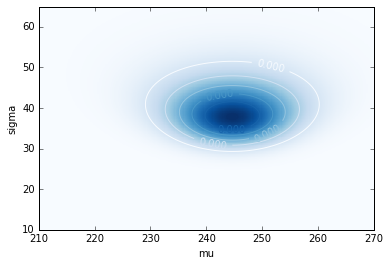

In [8]:
thinkplot.Contour(general, pcolor=True)
thinkplot.Config(xlabel='mu', ylabel='sigma')

We see that our values of `mu` and `sigma` fit well within cutoff range.

Now, do the same for BRINK.

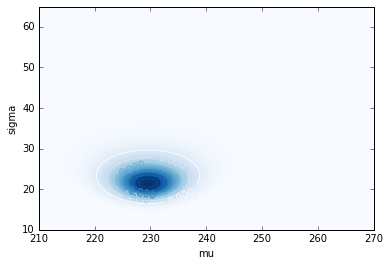

In [9]:
brink = Normal(product(mus, sigmas))
data = df[df.BRINK==1].RATIO
brink.Update(data)

thinkplot.Contour(brink, pcolor=True)
thinkplot.Config(xlabel='mu', ylabel='sigma')

Finally, to get a distribution of possible ratio values, we extract the marginal distributions of `mu` from both the general contractors and BRINK.

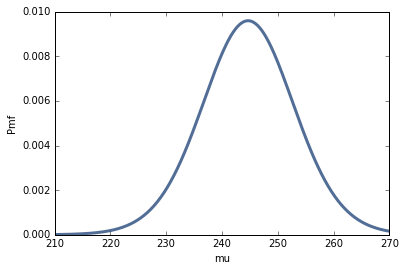

In [10]:
general_mu = general.Marginal(0)
thinkplot.Pdf(general_mu)
thinkplot.Config(xlabel='mu', ylabel='Pmf')

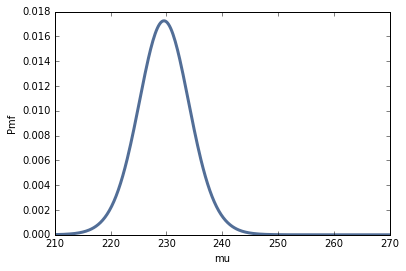

In [11]:
BRINK_mu = brink.Marginal(0)
thinkplot.Pdf(BRINK_mu)
thinkplot.Config(xlabel='mu', ylabel='Pmf')

To see how much money was stolen, we compute the difference of the marginal distributions. This immediately gives us difference of the means of the ratios as we could have calcuated earlier.

In [12]:
pmf_diff = BRINK_mu - general_mu
pmf_diff.Mean()

-15.022318455572226

To calculate the probability that money was stolen from the city, we simply look at a plot of the cdf of pmf_diff and see the probability that the difference is less than zero.

0.93875832542936855

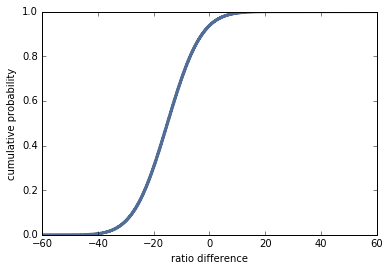

In [13]:
cdf_diff = pmf_diff.MakeCdf()
thinkplot.Cdf(cdf_diff)
thinkplot.Config(xlabel='ratio difference', ylabel='cumulative probability')
cdf_diff[0]

And we have answered the first question: the probability that money was stolen from the city is 93.9%

And lastly, we calculate how much money was stolen from the city. To do this, we first calculate how much money the city collected during (general or Brink) times. Then we can multiply this times our pmf_diff to get a probability distribution of potential stolen money.

(-3594455.9999999991, -1431125.9999999991)


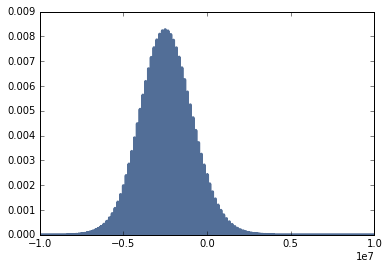

In [14]:
money_city = np.where(df['BRINK']==1, df['CITY'], 0).sum(0)
print((pmf_diff * money_city).CredibleInterval(50))
thinkplot.Pmf(pmf_diff * money_city)

Above we see a plot of stolen money in millions. We have also calculated a credible interval that tells us that there is a 50% chance that Brink stole between 1.4 to 3.6 million dollars. Interestingly, our distribution tells us that there is a probability that BRINK actually gave the city money. However, this is extremely unlikely and is an artifact of our normal distribution.

# How good is that cereal?
http://lib.stat.cmu.edu/DASL/Datafiles/Cereals.html

In [28]:
df = pd.read_csv('cereal.csv', skiprows=0, delimiter='\t')
df = df[['name','calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo', 'sugars', 'potass', 'cups', 'rating']]
df.head()

,name,calories,protein,fat,sodium,fiber,carbo,sugars,potass,cups,rating
0,100%_Bran,70,4,1,130,10,5,6,280,0.33,68.402973
1,100%_Natural_Bran,120,3,5,15,2,8,8,135,1.00,33.983679
2,All-Bran,70,4,1,260,9,7,5,320,0.33,59.425505
3,All-Bran_with_Extra_Fiber,50,4,0,140,14,8,0,330,0.50,93.704912
4,Almond_Delight,110,2,2,200,1,14,8,-1,0.75,34.384843


In [29]:
numerics = ['calories','protein','fat','sodium','fiber','carbo', 'sugars', 'potass', 'cups']

In [30]:
for column in numerics:
    df[column] = df[column] / df['cups']

In [31]:
df.head()

,name,calories,protein,fat,sodium,fiber,carbo,sugars,potass,cups,rating
0,100%_Bran,212.121212,12.121212,3.030303,393.939394,30.303030,15.151515,18.181818,848.484848,1,68.402973
1,100%_Natural_Bran,120.000000,3.000000,5.000000,15.000000,2.000000,8.000000,8.000000,135.000000,1,33.983679
2,All-Bran,212.121212,12.121212,3.030303,787.878788,27.272727,21.212121,15.151515,969.696970,1,59.425505
3,All-Bran_with_Extra_Fiber,100.000000,8.000000,0.000000,280.000000,28.000000,16.000000,0.000000,660.000000,1,93.704912
4,Almond_Delight,146.666667,2.666667,2.666667,266.666667,1.333333,18.666667,10.666667,-1.333333,1,34.384843


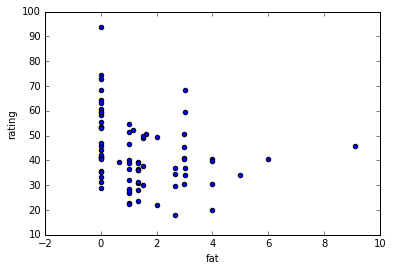

In [32]:
df.plot('fat', 'rating', kind='scatter')